## Oxford-IIIT Pet Dataset 을 이용하여 colorization 학습하기

이 실습에서는 미리 저장된 tfrecord file을 읽어와서 unet과 비슷한 network을 이용항 colorization을 학습시켜 봅니다.

### 이 실습 file부터 진행하는 경우 준비사항
9_1을 건너뛰고 이번 file부터 실습을 하는 경우 아래 경로에서 tfrecord file을 다운 받은 후,  
train tfrecord file:  https://drive.google.com/file/d/1lejq39iRTpQjKH4iZwoL_hCyxzXgoaox/view?usp=sharing  
validation tfrecord file: https://drive.google.com/file/d/1qiqEJkcdaHWJUSTX43X-PsihM8PZ6_gt/view?usp=sharing 

실습 directory에 dogs_tfr 이라는 이름의 directory를 생성하고 위에서 download 받은 file을 upload 해야 실습이 진행 가능합니다

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


In [14]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate, Softmax

In [3]:
cd '/content/gdrive/My Drive/TensorFlow_Training_13th'

In [19]:
## hyper parameter 설정
batch_size = 10
learning_rate = 0.0001
training_epochs = 20
img_size = 224
n_train = 2000
n_val = 498

In [20]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [21]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'seg': tf.io.FixedLenFeature([], tf.string),
              'grayimg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)
    seg = tf.reshape(seg, [img_size, img_size, -1])
    seg = tf.cast(seg, tf.float32)
    
    grayimg = tf.io.decode_raw(parsed_features['grayimg'], tf.float64)    
    grayimg = tf.reshape(grayimg, [img_size, img_size])
    grayimg = tf.stack([grayimg, grayimg, grayimg], -1)
    grayimg = tf.cast(grayimg, tf.float32)/255.
    print(grayimg.shape)
    
    #return image, seg
    return grayimg, image

In [22]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
#train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).shuffle(n_train*2).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

(224, 224, 3)


In [23]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

(224, 224, 3)


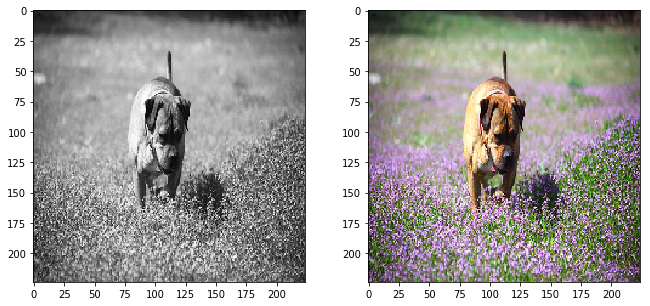

In [24]:
## train dataset에서 1개의 grayscale image와 원본 image를 읽어서 확인
for grayimg, image in val_dataset.take(1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plt.imshow(grayimg[0])
    plt.subplot(1,2,2)    
    plt.imshow(image[0]) 
    plt.show()  

In [27]:
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(3, 1, 1, 'SAME', activation='sigmoid')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12)

In [28]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_34[0][0]                  
____________________________________________________________________________________________

In [29]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [30]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/20
200/200 [==============================] - 81s 404ms/step - loss: 0.0323 - val_loss: 0.0170
Epoch 2/20
200/200 [==============================] - 71s 356ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 3/20
200/200 [==============================] - 71s 357ms/step - loss: 0.0096 - val_loss: 0.0074
Epoch 4/20
200/200 [==============================] - 71s 357ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 5/20
200/200 [==============================] - 72s 358ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/20
200/200 [==============================] - 71s 357ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 7/20
200/200 [==============================] - 72s 359ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 8/20
200/200 [==============================] - 72s 358ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 9/20
200/200 [==============================] - 71s 357ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 10/20
200/200 [==============================] - 71s 354ms/step - l

### pretrained weight load(optinal)
미리 학습된 weight를 가져와서 학습할 경우 아래 comment를 지우고 load_weights를 실행  
미리 학습된 weight 위치: https://drive.google.com/file/d/1y9go3pky8n5FWDvvChVJz-mc2_eTEA4w/view?usp=sharing  
위 link에서 .h5 파일을 download한 후에 실습 directory에 'saved_weights'라는 directory를 만든 후 .h5 파일을 upload

In [ ]:
#weight_path = ('./saved_weights/colorization_vgg.h5')
#model.load_weights(weight_path)

In [31]:
prediction = model.predict(val_dataset)

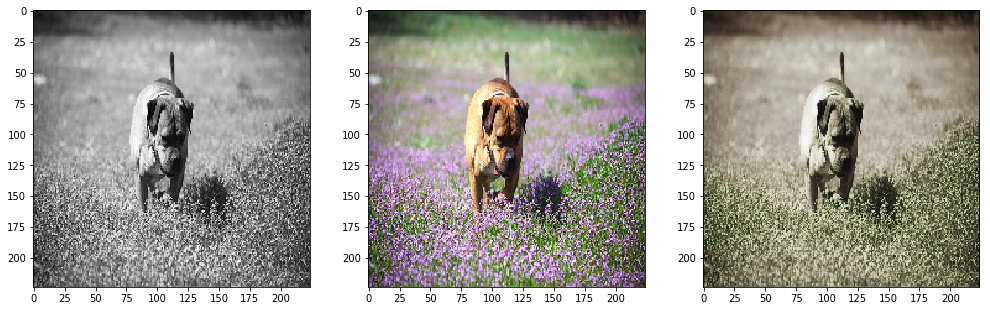

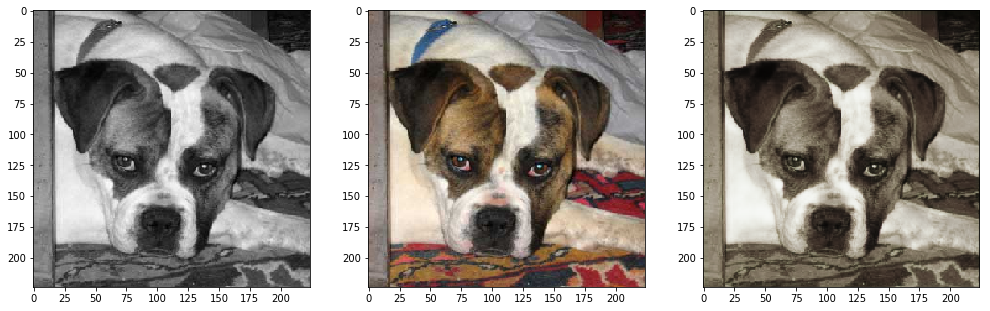

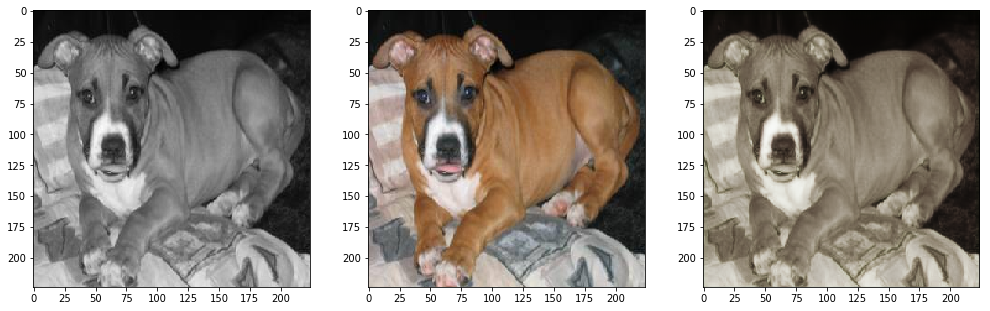

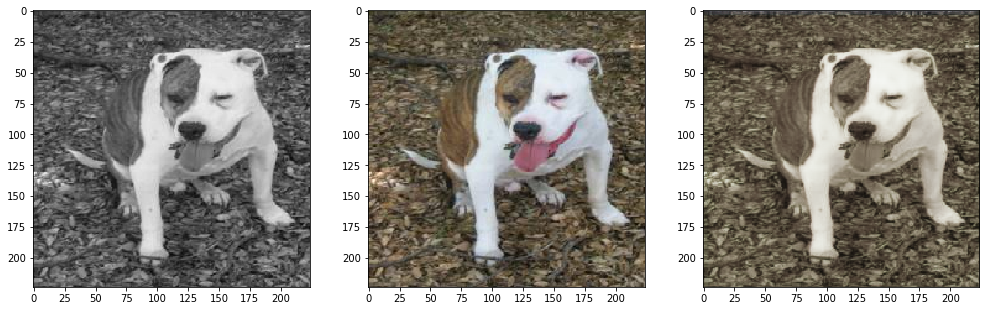

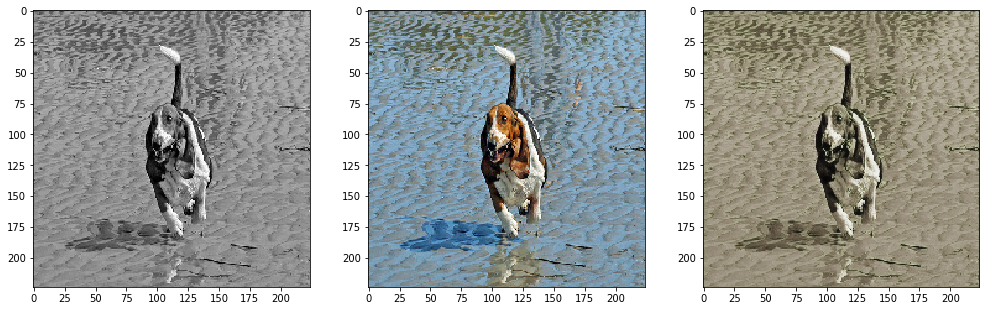

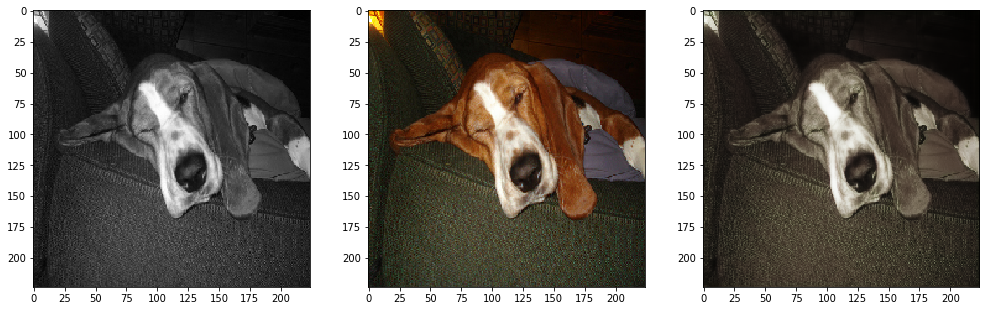

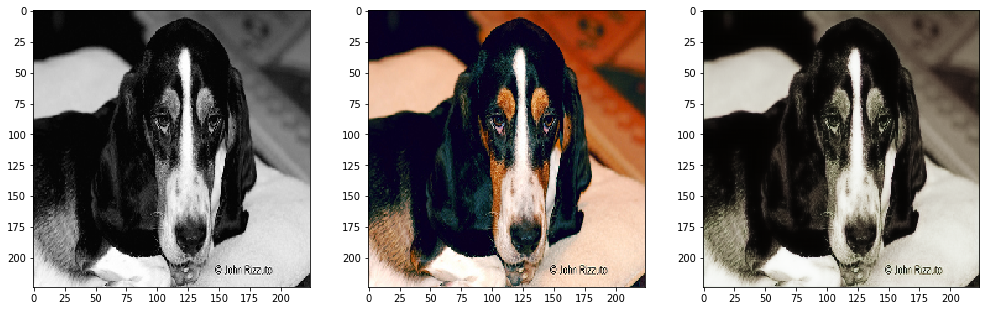

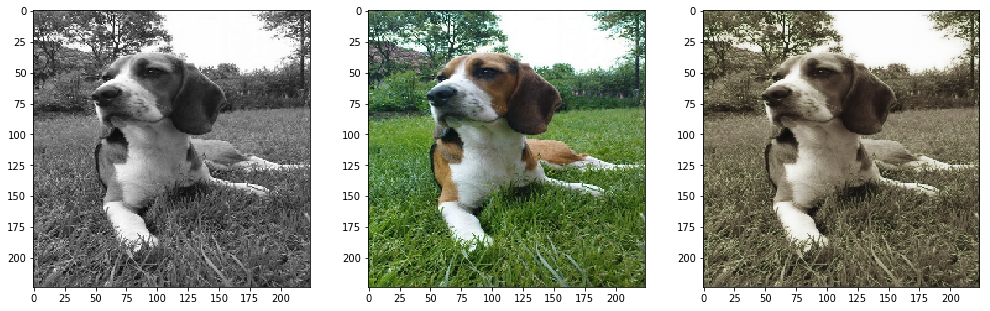

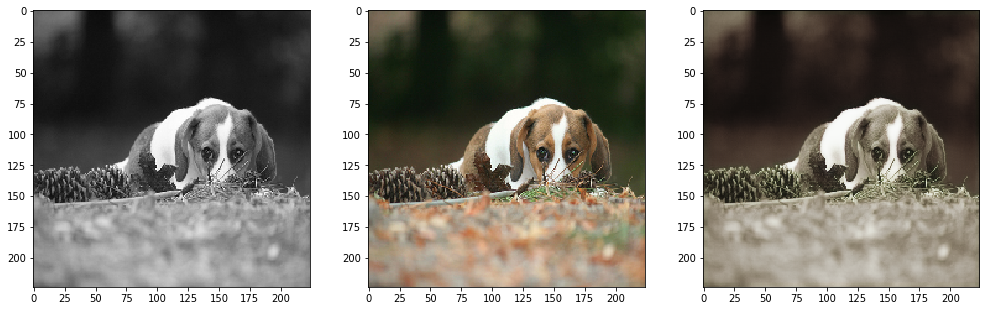

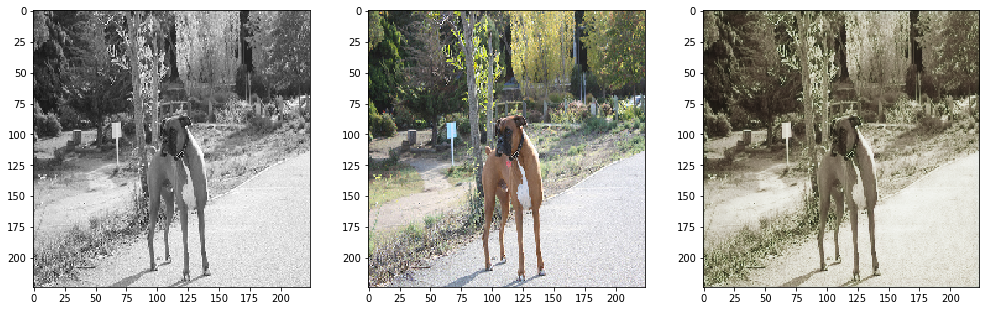

In [33]:
## 결과 확인
num_imgs = 10
idx = 0
for grayimg, image in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(grayimg[0], cmap='gray')
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(image[0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(prediction[idx*batch_size])
    plt.show() 
    idx += 1